In [17]:
import pandas as pd
import numpy as np
import math
from datetime import date

import yfinance as yf

from scipy.signal import argrelextrema
from scipy.stats import percentileofscore

import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import  to_rgba


In [18]:
# Loading the dataset
start_date = "2000-01-01"
end_date = date.today().strftime('%Y-%m-%d')
data = yf.download('^NSEI', start=start_date, end=end_date, progress=False)

# Renaming the columns
data.columns = data.columns.get_level_values(0) 
data.reset_index(inplace=True) 
data = data[['Date', 'Open', 'High', 'Low', 'Close']].copy() 
data.columns = ['date', 'open', 'high', 'low', 'close']

# Changing the Datetime Format
data['date'] = pd.to_datetime(data['date'])

# Ensuring Data Sanity
data.drop_duplicates(subset=['date'], inplace=True)
data.sort_values('date', inplace=True)

In [19]:
# Detrended Price using 200 day Simple Moving Average
trend_window = 200
trend = data['close'].rolling(window=trend_window).mean()
data['trend'] = trend

# Percentage deviation of "close" from trend
data['detrended_price'] = ((data['close'] - data['trend']) / data['trend'])*100

# Using hidrick preston filter to find trend highs/lows which are then used to find the swing highs/lows
cycle, trendX = sm.tsa.filters.hpfilter(data['close'], lamb=25)
data['smtrend'] = trendX
data['trend_high'] = data[(data.smtrend > data.smtrend.shift(1)) & (data.smtrend > data.smtrend.shift(-1))]['close']
data['trend_low'] = data[(data.smtrend < data.smtrend.shift(1)) & (data.smtrend < data.smtrend.shift(-1))]['close']

# # Binary tagging the candles for the same
data['swing_high'] = data['trend_high'].notna().astype(int)
data['swing_low'] = data['trend_low'].notna().astype(int)

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


In [20]:
data.drop(columns=['trend_high', 'trend_low'], inplace=True)

In [21]:
support_candidates = (
    data[data['swing_low'] == 1]
    .loc[:, ['date', 'low']]
    .rename(columns={'low': 'price'})
    .copy()
)
support_candidates['type'] = 'support'
support_candidates.reset_index(drop=True, inplace=True)

resistance_candidates = (
    data[data['swing_high'] == 1]
    .loc[:, ['date', 'high']]
    .rename(columns={'high': 'price'})
    .copy()
)
resistance_candidates['type'] = 'resistance'
resistance_candidates.reset_index(drop=True, inplace=True)

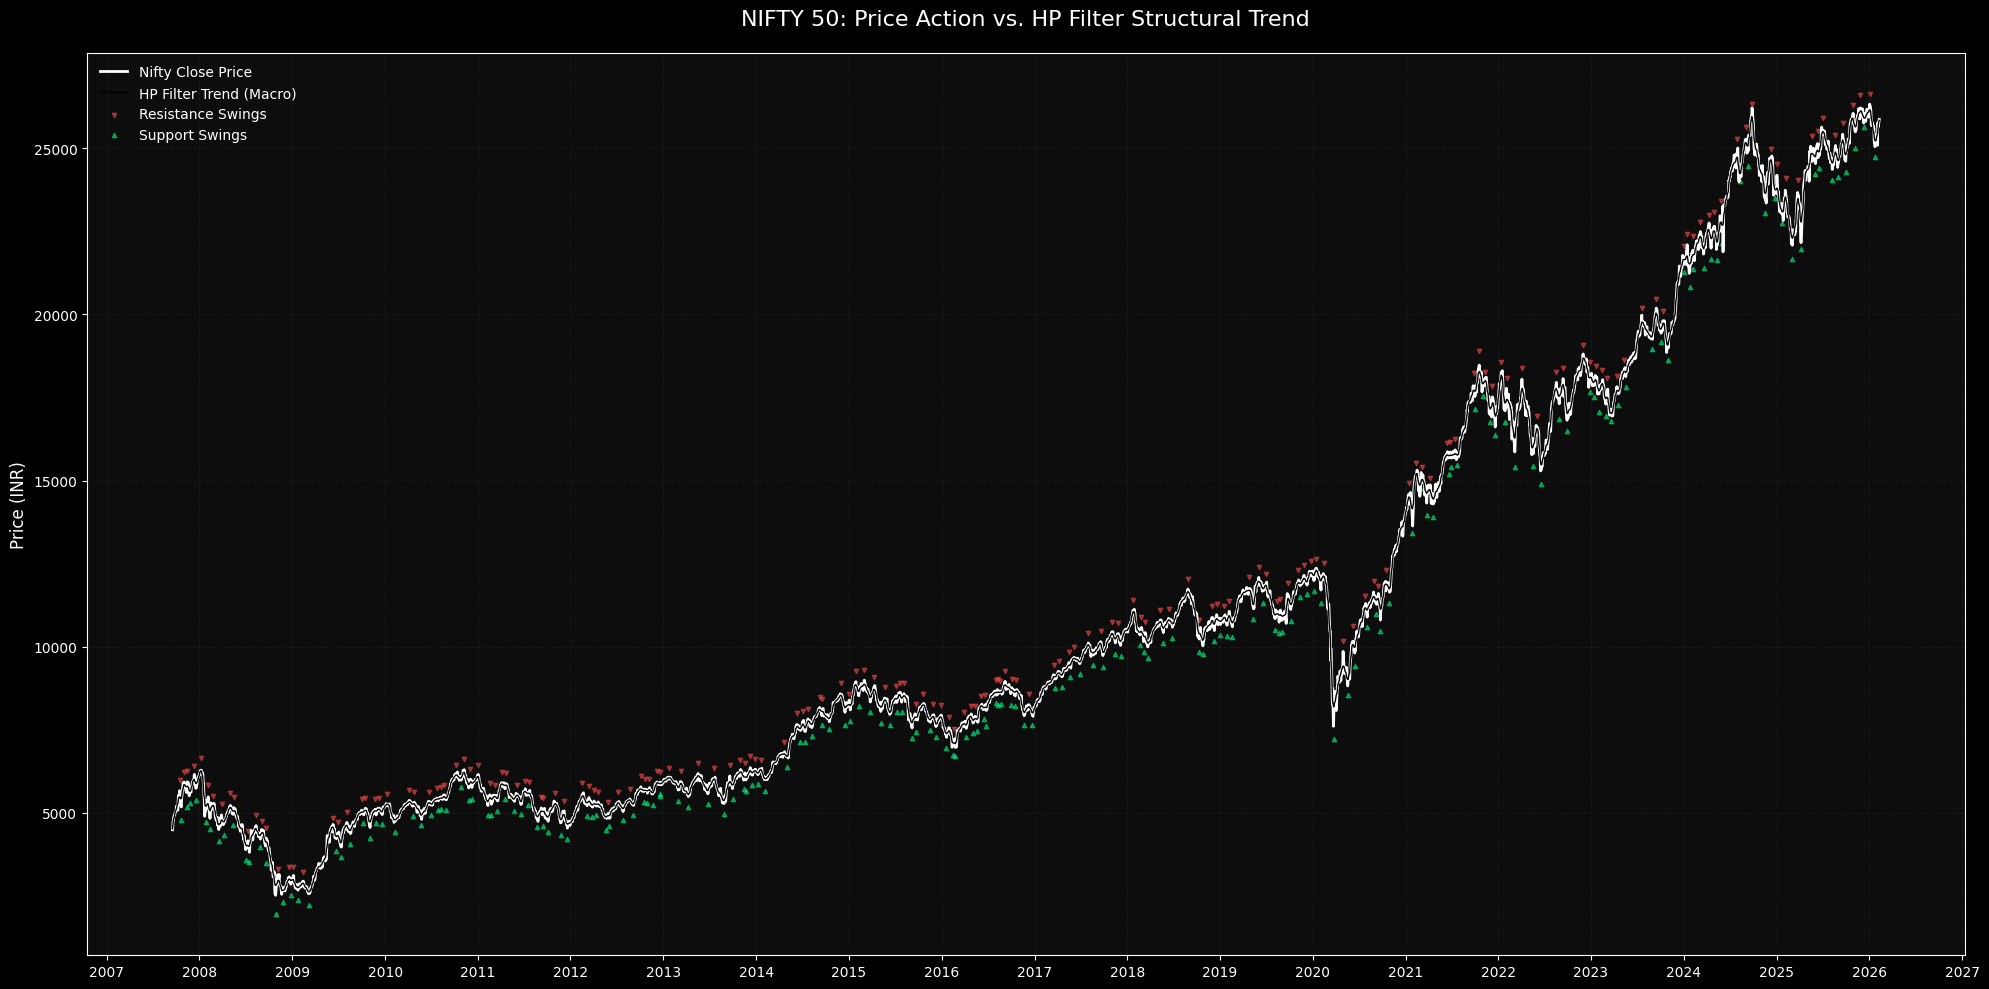

In [22]:
# Set the dark style
plt.style.use('dark_background')

# 1. Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), facecolor='black')
ax.set_facecolor('#0d0d0d')

# 2. Plot the Nifty Close price (faint background)
ax.plot(data['date'], data['close'], color="#ffffff", linewidth=2, label='Nifty Close Price')

# 3. Plot the HP Filter Trend (vibrant neon line)
# Note: We use the 'trend' column generated by sm.tsa.filters.hpfilter()
ax.plot(data['date'], data['smtrend'], color="#000000", linewidth=1, label='HP Filter Trend (Macro)')

# 4. Plot Swing Points (Optional: keeping these to show how they relate to the trend)
ax.scatter(resistance_candidates['date'], resistance_candidates['price']+300, 
           color='#ff4d4d', s=10, marker='v', alpha=0.5, label='Resistance Swings')

ax.scatter(support_candidates['date'], support_candidates['price']-300, 
           color='#00ff88', s=10, marker='^', alpha=0.5, label='Support Swings')

# 5. Formatting
ax.set_title("NIFTY 50: Price Action vs. HP Filter Structural Trend", color='white', fontsize=16, pad=20)
ax.set_ylabel("Price (INR)", color='white', fontsize=12)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.tick_params(colors='white', which='both', labelsize=10)

# Subtle grid for reference
ax.grid(True, color='#333333', linestyle='--', alpha=0.3)

# Legend placement
ax.legend(loc='upper left', frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

In [23]:
# Compute True Range
high_low = data['high'] - data['low']  # current high minus current low
high_close = (data['high'] - data['close'].shift(1)).abs() # absolute of current high minus prev day's close
low_close = (data['low'] - data['close'].shift(1)).abs() # absolute of current low minus previous day's close
data['true_range'] = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1) # selecting the maximum out of the above three

In [24]:
atr_window = 14
data['atr'] = data['true_range'].rolling(window=atr_window, min_periods=atr_window).mean()

In [25]:
support_candidates = support_candidates.merge(
    data[['date', 'atr']],
    on='date',
    how='left'
)
resistance_candidates = resistance_candidates.merge(
    data[['date', 'atr']],
    on='date',
    how='left'
)

# Removing early period NaNs
support_candidates.dropna(subset=['atr'], inplace=True)
resistance_candidates.dropna(subset=['atr'], inplace=True)

In [26]:
assert support_candidates['atr'].gt(0).all()
assert resistance_candidates['atr'].gt(0).all()

print(support_candidates['atr'].describe())
print(resistance_candidates['atr'].describe())

count    187.000000
mean     147.711391
std       79.895610
min       52.092878
25%       91.255301
50%      122.853864
75%      191.508789
max      675.421456
Name: atr, dtype: float64
count    187.000000
mean     135.289357
std       67.488533
min       52.467878
25%       83.983974
50%      114.146449
75%      172.294678
max      327.832310
Name: atr, dtype: float64


In [27]:
# --- 1. THE STRUCTURAL CLUSTERING LOGIC ---
def identify_structural_zones(candidates, k_atr=2.0):
    if candidates.empty: return pd.DataFrame()
    
    # Sort chronologically
    candidates = candidates.sort_values('date').reset_index(drop=True)
    zones = []

    for _, swing in candidates.iterrows():
        found_match = False
        
        # Check against existing zones
        for zone in zones:
            current_mean = zone['price_sum'] / zone['count']
            # Dynamic threshold based on volatility AT THE TIME
            threshold = k_atr * swing['atr']
            
            if abs(swing['price'] - current_mean) < threshold:
                zone['price_sum'] += swing['price']
                zone['count'] += 1
                zone['last_seen'] = swing['date']
                # Store BOTH date and price for the plot
                zone['swings'].append({'date': swing['date'], 'price': swing['price']})
                found_match = True
                break
        
        if not found_match:
            # Start a new structural zone
            zones.append({
                'type': swing['type'],
                'first_seen': swing['date'],
                'last_seen': swing['date'],
                'price_sum': swing['price'],
                'count': 1,
                'swings': [{'date': swing['date'], 'price': swing['price']}]
            })

    # Convert to DataFrame
    zone_df = pd.DataFrame(zones)
    
    # Filter: Keep only zones with at least 2 touches
    if not zone_df.empty:
        zone_df = zone_df[zone_df['count'] >= 2].copy()
        
        # Calculate Geometry
        zone_df['mean'] = zone_df['price_sum'] / zone_df['count']
        zone_df['std'] = zone_df['swings'].apply(lambda x: np.std([s['price'] for s in x]))
        
        # Zone Width (Mean +/- 1 Std Dev) with min buffer
        zone_df['upper'] = zone_df.apply(lambda x: max(x['mean'] + x['std'], x['mean'] * 1.002), axis=1)
        zone_df['lower'] = zone_df.apply(lambda x: min(x['mean'] - x['std'], x['mean'] * 0.998), axis=1)
        
    return zone_df

# --- 2. EXECUTE IDENTIFICATION ---
# We overwrite the variables to ensure we are plotting the NEW data structure
support_zones = identify_structural_zones(support_candidates, k_atr=2)
resistance_zones = identify_structural_zones(resistance_candidates, k_atr=2)


In [28]:
# --- PHASE 1: BIRTH (INITIALIZATION) ---
def birth_zones(structural_df, zone_type):
    living_zones = []
    if structural_df.empty: return living_zones

    for index, row in structural_df.iterrows():
        # Calculate initial variance
        initial_std = row['std']
        if initial_std == 0: initial_std = row['mean'] * 0.001 

        zone = {
            'id': f"{zone_type}_{index}",
            'type': zone_type,
            'birth_date': row['first_seen'],
            
            # Geometry
            'mean': row['mean'],
            'variance': initial_std ** 2,
            'std': initial_std,
            'upper': row['upper'],
            'lower': row['lower'],
            'min_width': row['mean'] * 0.0015,
            
            # Lifecycle
            'strength': 1.0,
            'status': 'ALIVE',
            'locked': False,
            'age_days': 0,
            'touch_count': row['count'],
            'last_interaction': row['last_seen'],
            'death_date': pd.NaT,
            
            # --- NEW: HISTORY RECORDER ---
            # We will store the state of the zone for every single day it exists.
            # Format: [Date, Mean, Upper, Lower, Strength]
            'history': [] 
        }
        living_zones.append(zone)
    return living_zones

# Initialize
living_support = birth_zones(support_zones, 'Support')
living_resistance = birth_zones(resistance_zones, 'Resistance')

In [29]:
# --- PHASE 2 & 3: THE UNIFIED LIFECYCLE ENGINE ---
def simulate_lifecycle_engine(support_zones, resistance_zones, market_data):
    # 1. Sort Data
    market_data = market_data.sort_values('date').reset_index(drop=True)
    print(f"Starting Engine with {len(support_zones)} Support and {len(resistance_zones)} Resistance zones...")
    
    for i, row in market_data.iterrows():
        current_date = row['date']
        curr_close = row['close']
        curr_high = row['high']
        curr_low = row['low']
        curr_atr = row['atr']
        
        if pd.isna(curr_atr): continue

        # Fix: Instantaneous Volatility for Crashes
        effective_vol = max(curr_atr, curr_high - curr_low)
        
        # Buffers for Polarity Flips
        new_resistances = []
        new_supports = []

        # Helper to process a list of zones
        def process_zones(zones, z_type, opposite_list_buffer):
            for zone in zones:
                if zone['status'] == 'DEAD': continue
                if current_date < zone['birth_date']: continue

                # --- RECORD HISTORY (The "Black Box") ---
                # We save the state BEFORE calculating death (so we see the moment it dies)
                zone['history'].append({
                    'date': current_date,
                    'mean': zone['mean'],
                    'upper': zone['upper'],
                    'lower': zone['lower'],
                    'strength': zone['strength']
                })

                # --- PHASE 3: DEATH ---
                is_dead = False
                
                # Support Logic
                if z_type == 'Support':
                    # Close Break or Wick Destruction
                    if (curr_close < zone['lower'] - 2.0 * effective_vol) or \
                       (curr_low < zone['lower'] - 3.0 * effective_vol):
                        is_dead = True
                
                # Resistance Logic
                elif z_type == 'Resistance':
                    if (curr_close > zone['upper'] + 2.0 * effective_vol) or \
                       (curr_high > zone['upper'] + 3.0 * effective_vol):
                        is_dead = True

                if is_dead:
                    zone['status'] = 'DEAD'
                    zone['death_date'] = current_date
                    
                    # POLARITY FLIP (Spawn new zone)
                    new_type = 'Resistance' if z_type == 'Support' else 'Support'
                    new_zone = {
                        'id': f"Flip_{zone['id']}",
                        'type': new_type,
                        'birth_date': current_date,
                        'mean': zone['mean'],
                        'variance': zone['variance'],
                        'std': zone['std'],
                        'upper': zone['upper'],
                        'lower': zone['lower'],
                        'min_width': zone['min_width'],
                        'strength': 0.5, # Penalty start
                        'status': 'ALIVE',
                        'locked': True,
                        'age_days': 0,
                        'touch_count': 0,
                        'last_interaction': current_date,
                        'death_date': pd.NaT,
                        'history': []
                    }
                    opposite_list_buffer.append(new_zone)
                    continue

                # --- PHASE 2: LIFE ---
                # Decay
                zone['strength'] *= 0.995
                zone['age_days'] += 1

                # Unlock
                if zone['locked']:
                    dist = abs(curr_close - zone['mean'])
                    if dist > 2.0 * effective_vol:
                        zone['locked'] = False

                # Interaction
                if not zone['locked']:
                    # Check Overlap
                    if (curr_low <= zone['upper']) and (curr_high >= zone['lower']):
                        # Boost
                        zone['strength'] = min(zone['strength'] + 0.2, 2.5)
                        zone['touch_count'] += 1
                        zone['last_interaction'] = current_date
                        zone['locked'] = True
                        
                        # RECENCY BIAS (Drift)
                        alpha = 0.2
                        old_mean = zone['mean']
                        zone['mean'] = (old_mean * (1 - alpha)) + (curr_close * alpha)
                        
                        # Width Breathing
                        diff = curr_close - old_mean
                        zone['variance'] = (1 - alpha) * (zone['variance'] + alpha * diff**2)
                        zone['std'] = math.sqrt(zone['variance'])
                        
                        # Bounds Update
                        final_std = max(zone['std'], zone['min_width'])
                        zone['upper'] = zone['mean'] + final_std
                        zone['lower'] = zone['mean'] - final_std

        # Process Both Lists
        process_zones(support_zones, 'Support', new_resistances)
        process_zones(resistance_zones, 'Resistance', new_supports)

        # Append New Polarity Zones
        if new_supports: support_zones.extend(new_supports)
        if new_resistances: resistance_zones.extend(new_resistances)

    print("Engine Complete.")

# Run
simulate_lifecycle_engine(living_support, living_resistance, data)

Starting Engine with 34 Support and 32 Resistance zones...
Engine Complete.


Plotting 140 Support zones (Hidden 0 ghosts).
Plotting 107 Resistance zones (Hidden 0 ghosts).


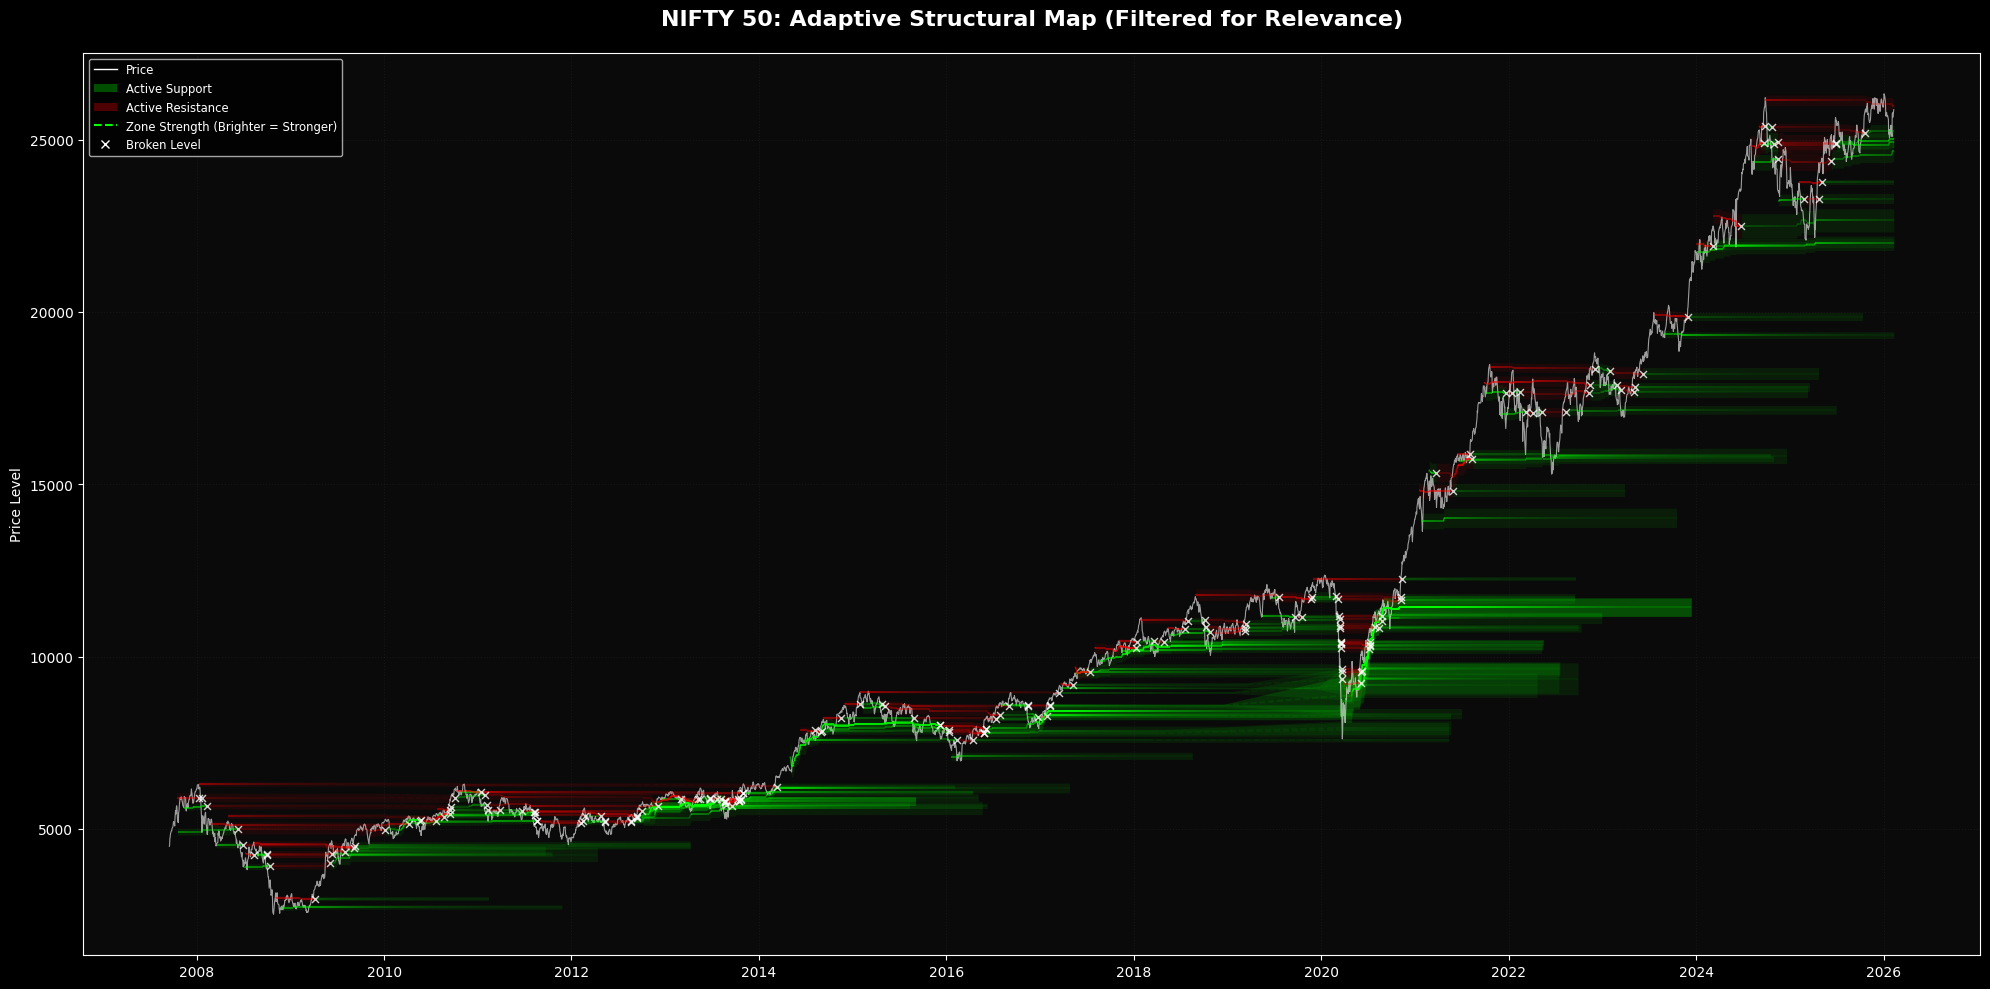

In [32]:
# --- PHASE 4: VISUALIZATION (Cleaned & Masked) ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20, 10), facecolor='black')
ax.set_facecolor('#0a0a0a')

# Plot Price (Thinner line to emphasize zones)
ax.plot(data['date'], data['close'], color='white', alpha=0.6, linewidth=0.8, label='Close Price')

def plot_zone_history_cleaned(ax, zones, color_hex, label):
    visible_count = 0
    # Convert hex to rgba for the fill
    base_rgba = to_rgba(color_hex)
    
    for zone in zones:
        if not zone['history']: continue
        
        # 1. Extract History
        hist_df = pd.DataFrame(zone['history'])
        
        # --- CRITICAL FIX: FILTER WEAK POINTS ---
        # We only keep days where the zone had meaningful strength (> 0.05)
        # This creates "gaps" where the zone is forgotten, removing the clutter.
        mask = hist_df['strength'] > 0.05
        
        # If the whole zone is weak, skip it
        if not mask.any(): continue
        
        # Apply mask to data
        valid_df = hist_df[mask]
        
        dates = valid_df['date'].values
        means = valid_df['mean'].values
        uppers = valid_df['upper'].values
        lowers = valid_df['lower'].values
        strengths = valid_df['strength'].values
        
        # 2. Draw the "Tunnel" (Fill)
        # We use a very low alpha (0.05) to avoid the "Solid Block" effect when zones stack
        # We plot this using 'fill_between' on the masked data. 
        # Note: Gaps in dates will result in straight lines connecting segments, 
        # which is acceptable for visual continuity, or we can split loops (more complex).
        ax.fill_between(dates, lowers, uppers, color=color_hex, alpha=0.08, linewidth=0, zorder=1)
        
        # 3. Draw the "Mean Line" (Gradient Strength)
        # This is the most important visual element
        date_nums = mdates.date2num(dates)
        points = np.array([date_nums, means]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Map strength to Alpha (0.0 to 1.0)
        # We use the strength of the *start* of each segment
        seg_strengths = strengths[:-1]
        alphas = np.clip(seg_strengths * 0.5, 0.05, 0.9)
        
        lc = LineCollection(segments, colors=color_hex, linestyle='--', linewidth=1.2, zorder=2)
        lc.set_alpha(alphas)
        ax.add_collection(lc)
        
        # 4. Mark Death (Only if it happened)
        if pd.notnull(zone['death_date']):
             ax.scatter(zone['death_date'], zone['mean'], 
                        color='white', marker='x', s=25, alpha=0.8, zorder=3, linewidth=1)
             
        visible_count += 1

    print(f"Plotting {visible_count} {label} zones (Hidden {len(zones)-visible_count} ghosts).")

# Execute Plotter
plot_zone_history_cleaned(ax, living_support, '#00ff00', 'Support')
plot_zone_history_cleaned(ax, living_resistance, '#ff0000', 'Resistance')

# Formatting
ax.set_title("NIFTY 50: Adaptive Structural Map (Filtered for Relevance)", color='white', fontsize=16, fontweight='bold', pad=20)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, color='#333333', linestyle=':', alpha=0.3)
ax.set_ylabel("Price Level", color='white')

# Legend
legend_elements = [
    Line2D([0], [0], color='white', lw=1, label='Price'),
    Patch(facecolor='#00ff00', alpha=0.3, label='Active Support'),
    Patch(facecolor='#ff0000', alpha=0.3, label='Active Resistance'),
    Line2D([0], [0], color='#00ff00', linestyle='--', label='Zone Strength (Brighter = Stronger)'),
    Line2D([0], [0], marker='x', color='white', linestyle='None', label='Broken Level')
]
ax.legend(handles=legend_elements, loc='upper left', facecolor='black', fontsize='small')

plt.tight_layout()
plt.show()